## Importar librarias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential #mutilayer perceptor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.5.0


## Ler dataset

In [3]:
training_data = pd.read_csv("training_data.csv", encoding='latin-1')
test_data = pd.read_csv("test_data.csv", encoding='latin-1')

## Preparar o dataset

#### Fazer drop das features desnecessarias

In [4]:
#City name é sempre porto logo pode-se fazer drop
#Drop
training_data = training_data.drop(['city_name'], axis=1)
test_data = test_data.drop(['city_name'], axis=1)
#Average percipitation é sempre 0 logo pode-se fazer drop
training_data = training_data.drop(['AVERAGE_PRECIPITATION'], axis=1)
test_data = test_data.drop(['AVERAGE_PRECIPITATION'], axis=1)

#### Remover outliers

In [5]:
#Remover outliers da training_data
training_data['AVERAGE_FREE_FLOW_SPEED']=winsorize(training_data['AVERAGE_FREE_FLOW_SPEED'],(0.01,0.02))
training_data['AVERAGE_TIME_DIFF']=winsorize(training_data['AVERAGE_TIME_DIFF'],(0.01,0.01))
training_data['AVERAGE_FREE_FLOW_TIME']=winsorize(training_data['AVERAGE_FREE_FLOW_TIME'],(0.02,0.02))
training_data['AVERAGE_TEMPERATURE']=winsorize(training_data['AVERAGE_TEMPERATURE'],(0.01,0.02))
training_data['AVERAGE_ATMOSP_PRESSURE']=winsorize(training_data['AVERAGE_ATMOSP_PRESSURE'],(0.04,0.02))
training_data['AVERAGE_HUMIDITY']=winsorize(training_data['AVERAGE_HUMIDITY'],(0.03,0.02))
training_data['AVERAGE_WIND_SPEED']=winsorize(training_data['AVERAGE_WIND_SPEED'],(0.01,0.02))
#Remover outlier das testing_data
test_data['AVERAGE_FREE_FLOW_SPEED']=winsorize(test_data['AVERAGE_FREE_FLOW_SPEED'],(0.01,0.02))
test_data['AVERAGE_TIME_DIFF']=winsorize(test_data['AVERAGE_TIME_DIFF'],(0.01,0.01))
test_data['AVERAGE_FREE_FLOW_TIME']=winsorize(test_data['AVERAGE_FREE_FLOW_TIME'],(0.02,0.02))
test_data['AVERAGE_TEMPERATURE']=winsorize(test_data['AVERAGE_TEMPERATURE'],(0.01,0.02))
test_data['AVERAGE_ATMOSP_PRESSURE']=winsorize(test_data['AVERAGE_ATMOSP_PRESSURE'],(0.04,0.02))
test_data['AVERAGE_HUMIDITY']=winsorize(test_data['AVERAGE_HUMIDITY'],(0.03,0.01))
test_data['AVERAGE_WIND_SPEED']=winsorize(test_data['AVERAGE_WIND_SPEED'],(0.01,0.02))

In [6]:
#Precisamos de escalar certos valores para 0-1
training_data['AVERAGE_FREE_FLOW_SPEED'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_FREE_FLOW_SPEED']).reshape(-1,1))
training_data['AVERAGE_TIME_DIFF'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_TIME_DIFF']).reshape(-1,1))
training_data['AVERAGE_FREE_FLOW_TIME'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_FREE_FLOW_TIME']).reshape(-1,1))
training_data['AVERAGE_TEMPERATURE'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_TEMPERATURE']).reshape(-1,1))
training_data['AVERAGE_ATMOSP_PRESSURE'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_ATMOSP_PRESSURE']).reshape(-1,1))
training_data['AVERAGE_HUMIDITY'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_HUMIDITY']).reshape(-1,1))
training_data['AVERAGE_WIND_SPEED'] = MinMaxScaler().fit_transform(np.array(training_data['AVERAGE_WIND_SPEED']).reshape(-1,1))

test_data['AVERAGE_FREE_FLOW_SPEED'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_FREE_FLOW_SPEED']).reshape(-1,1))
test_data['AVERAGE_TIME_DIFF'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_TIME_DIFF']).reshape(-1,1))
test_data['AVERAGE_FREE_FLOW_TIME'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_FREE_FLOW_TIME']).reshape(-1,1))
test_data['AVERAGE_TEMPERATURE'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_TEMPERATURE']).reshape(-1,1))
test_data['AVERAGE_ATMOSP_PRESSURE'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_ATMOSP_PRESSURE']).reshape(-1,1))
test_data['AVERAGE_HUMIDITY'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_HUMIDITY']).reshape(-1,1))
test_data['AVERAGE_WIND_SPEED'] = MinMaxScaler().fit_transform(np.array(test_data['AVERAGE_WIND_SPEED']).reshape(-1,1))

### Aproveitar a date para usar as horas

In [7]:
dfdate= pd.to_datetime(training_data['record_date'])
# define the bins
bins = [0, 7, 11, 14, 17, 19, 21, 24]
# add custom labels if desired
labels = ['00:00-06:59', '07:00-10:59', '11:00-13:59', '14:00-16:59', '17:00-18:59', '19:00-20:59', '21:00-23:59']
# add the bins to the dataframe
training_data['Time Bin'] = pd.cut(dfdate.dt.hour, bins, labels=labels, right=False)
dfdate = pd.to_datetime(test_data['record_date'])
test_data['Time Bin'] = pd.cut(dfdate.dt.hour, bins, labels=labels, right=False)
def ismeia(cols):
    TimeBin=cols
    if TimeBin==labels[0]:
        return 1
    else:
        return 0    
def issete(cols):
    TimeBin=cols
    if TimeBin==labels[1]:
        return 1
    else:
        return 0
def isonze(cols):
    TimeBin=cols
    if TimeBin==labels[2]:
        return 1
    else:
        return 0    
def isquatorze(cols):
    TimeBin=cols
    if TimeBin==labels[3]:
        return 1
    else:
        return 0    
def isdessasete(cols):
    TimeBin=cols
    if TimeBin==labels[4]:
        return 1
    else:
        return 0  
def isdezanove(cols):
    TimeBin=cols
    if TimeBin==labels[5]:
        return 1
    else:
        return 0
def isvinteum(cols):
    TimeBin=cols
    if TimeBin==labels[6]:
        return 1
    else:
        return 0  

#Adicionar a training_data
training_data[labels[0]] = training_data['Time Bin'].apply(ismeia)
training_data[labels[1]] = training_data['Time Bin'].apply(issete)
training_data[labels[2]] = training_data['Time Bin'].apply(isonze)
training_data[labels[3]] = training_data['Time Bin'].apply(isquatorze)
training_data[labels[4]] = training_data['Time Bin'].apply(isdessasete)
training_data[labels[5]] = training_data['Time Bin'].apply(isdezanove)
training_data[labels[6]] = training_data['Time Bin'].apply(isvinteum)
training_data=training_data.drop('Time Bin',axis=1)
#Adicionar a test_data
test_data[labels[0]] = test_data['Time Bin'].apply(ismeia)
test_data[labels[1]] = test_data['Time Bin'].apply(issete)
test_data[labels[2]] = test_data['Time Bin'].apply(isonze)
test_data[labels[3]] = test_data['Time Bin'].apply(isquatorze)
test_data[labels[4]] = test_data['Time Bin'].apply(isdessasete)
test_data[labels[5]] = test_data['Time Bin'].apply(isdezanove)
test_data[labels[6]] = test_data['Time Bin'].apply(isvinteum)
test_data=test_data.drop('Time Bin',axis=1)

#### Usar os dias da semana

In [8]:
def isweekday(cols):
    dayofweek=cols
    if dayofweek=='Saturday' or dayofweek=='Sunday':
        return 0
    else:
        return 1
#Training_data
dfdate= pd.to_datetime(training_data['record_date'])
asd= dfdate.dt.day_name()
training_data['IsDayOfWeek'] = asd.apply(isweekday)

#Test_data
dfdate= pd.to_datetime(test_data['record_date'])
asd= dfdate.dt.day_name()
test_data['IsDayOfWeek'] = asd.apply(isweekday)


training_data = training_data.drop(['record_date'], axis=1)
test_data = test_data.drop(['record_date'], axis=1)

### Tratar da AVERAGE_CLOUDINESS

Preencher os valores em falta pela mean

In [9]:
#Training_data
training_data.replace(to_replace ="céu claro", value = 0.999999, inplace = True)

training_data.replace(to_replace ="céu limpo", value = 0.999999, inplace = True)

training_data.replace(to_replace ="nuvens dispersas", value = 0.666666, inplace = True)

training_data.replace(to_replace ="algumas nuvens", value = 0.666666, inplace = True)

training_data.replace(to_replace ="céu pouco nublado", value = 0.666666, inplace = True)

training_data.replace(to_replace ="nuvens quebrados", value = 0.666666, inplace = True)

training_data.replace(to_replace ="nuvens quebradas", value = 0.666666, inplace = True)

training_data.replace(to_replace ="nublado", value = 0.333333, inplace = True)

training_data.replace(to_replace ="tempo nublado", value = 0.333333, inplace = True)

training_data.replace(to_replace ="NULL", value = 0.3, inplace = True)

training_data.replace(to_replace =r'^\s*$', value = 0.3, regex=True, inplace = True)

training_data["AVERAGE_CLOUDINESS"] = training_data["AVERAGE_CLOUDINESS"].fillna("MISSING VALUE")

dftmp = training_data[training_data["AVERAGE_CLOUDINESS"]!="MISSING VALUE"]

mediaRAS = dftmp.mean()

training_data.replace(to_replace ="MISSING VALUE", value = mediaRAS, inplace = True)

#Test_data

test_data.replace(to_replace ="céu claro", value = 0.999999, inplace = True)

test_data.replace(to_replace ="céu limpo", value = 0.999999, inplace = True)

test_data.replace(to_replace ="nuvens dispersas", value = 0.666666, inplace = True)

test_data.replace(to_replace ="algumas nuvens", value = 0.666666, inplace = True)

test_data.replace(to_replace ="céu pouco nublado", value = 0.666666, inplace = True)

test_data.replace(to_replace ="nuvens quebrados", value = 0.666666, inplace = True)

test_data.replace(to_replace ="nuvens quebradas", value = 0.666666, inplace = True)

test_data.replace(to_replace ="nublado", value = 0.333333, inplace = True)

test_data.replace(to_replace ="tempo nublado", value = 0.333333, inplace = True)

test_data.replace(to_replace ="NULL", value = 0.3, inplace = True)

test_data.replace(to_replace =r'^\s*$', value = 0.3, regex=True, inplace = True)

test_data["AVERAGE_CLOUDINESS"] = test_data["AVERAGE_CLOUDINESS"].fillna("MISSING VALUE")

dftmp = test_data[test_data["AVERAGE_CLOUDINESS"]!="MISSING VALUE"]

mediaRAS = dftmp.mean()

test_data.replace(to_replace ="MISSING VALUE", value = mediaRAS, inplace = True)

C:\Users\OBSESS~1\AppData\Local\Temp/ipykernel_13756/3087704650.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mediaRAS = dftmp.mean()
C:\Users\OBSESS~1\AppData\Local\Temp/ipykernel_13756/3087704650.py:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mediaRAS = dftmp.mean()


### Tratar da luminosity

In [10]:
training_data.replace(to_replace ="DARK", value = 0, inplace = True)
training_data.replace(to_replace ="LOW_LIGHT", value = 0.5, inplace = True)
training_data.replace(to_replace ="LIGHT", value = 1, inplace = True)

test_data.replace(to_replace ="DARK", value = 0, inplace = True)
test_data.replace(to_replace ="LOW_LIGHT", value = 0.5, inplace = True)
test_data.replace(to_replace ="LIGHT", value = 1, inplace = True)

### Tratar da Rain

In [11]:
test_data = test_data.drop(['AVERAGE_RAIN'], axis=1)
training_data = training_data.drop(['AVERAGE_RAIN'], axis=1)

## Construir o modelo

In [12]:
X = training_data.drop('AVERAGE_SPEED_DIFF', axis=1)
y = training_data[['AVERAGE_SPEED_DIFF']]

RANDOM_SEED = 10
tf.random.set_seed(42)

y = pd.get_dummies(y)

X = X.values
y = y.values

In [13]:
def build_model(activation='relu', learning_rate=0.01):
    # Create a sequential model with 3 layers - last one is output
    model = Sequential()
    model.add(Dense(17, input_dim=17, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(5, activation='relu'))
    
    # Compile the model
    # Define the loss function, the otimizer and metrics to be used
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['accuracy'])
    return model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [15]:
TUNING_DICT = {
    'activation' : ['relu', 'sigmoid'],
    'learning_rate' : [0.01, 0.001]
}

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model = KerasClassifier(build_fn=build_model, epochs=30, batch_size=16) 

grid_search = GridSearchCV(estimator = model,
                           param_grid = TUNING_DICT,
                           cv = kf,
                           scoring = 'accuracy',
                           refit = 'True',
                           verbose = 0)
grid_search.fit(X_train, y_train, validation_split=0.2, verbose=0)


C:\Users\obsession\anaconda3\envs\DAA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\obsession\anaconda3\envs\DAA\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\obsession\anaconda3\envs\DAA\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File 

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001B0B1BAA490>,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'learning_rate': [0.01, 0.001]},
             refit='True', scoring='accuracy')

In [17]:
#build_fn.predict()
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: nan using {'activation': 'relu', 'learning_rate': 0.01}
nan (nan) with: {'activation': 'relu', 'learning_rate': 0.01}
nan (nan) with: {'activation': 'relu', 'learning_rate': 0.001}
nan (nan) with: {'activation': 'sigmoid', 'learning_rate': 0.01}
nan (nan) with: {'activation': 'sigmoid', 'learning_rate': 0.001}


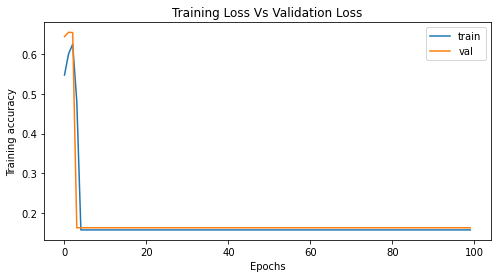

In [18]:
# Our best model
best_mlp_model = grid_search.best_estimator_
#Did the model overfit??
def plot_learning_curve(history, metric='accuracy'):
    plt.figure(figsize=(8,4))
    plt.title('Training Loss Vs Validation Loss')
    plt.plot(history.epoch, history.history['accuracy'], label='train')
    plt.plot(history.epoch, history.history['val_accuracy'], label='val')
    plt.ylabel('Training ' + metric)
    plt.xlabel('Epochs')
    plt.legend()
    
plot_learning_curve(best_mlp_model.model.history, metric='accuracy')

In [19]:
#Obtain predictions
predictions = best_mlp_model.predict(test_data)
predictions = predictions.reshape(predictions.shape[0], 1)
predictions[:50]

C:\Users\obsession\anaconda3\envs\DAA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])